## Portfolio Optimization with Parametric Optimization

This session explains how to use **parametric optimization** to solve a practical problem: constructing an optimized investment portfolio. The aim is to allocate funds among **real stocks** (Apple, Tesla, NVIDIA, Walmart, and JPMorgan) to maximize returns while minimizing risk. This is achieved by using historical stock data to model performance and employing mathematical optimization techniques.

---
### Optimization Process

1. **Defining the Objective**:
   - The primary goal is to **maximize the Sharpe ratio**, which measures risk-adjusted return:
     $$\text{Sharpe Ratio} = \frac{E[R_p] - R_f}{\sigma_p}$$
     Where:
     - $E[R_p]$: Expected portfolio return.
     - $R_f$: Risk-free rate.
     - $\sigma_p$: Portfolio volatility (risk).
   - This ensures the portfolio delivers the highest possible return for each unit of risk taken.

2. **Data Input**:
   - Historical price data for the selected stocks is fetched to calculate:
     - **Mean Returns**: Average performance of each stock.
     - **Covariance Matrix**: The relationship and variability between stock returns.

3. **Constraints**:
   - Portfolio weights must sum to 1:
     $
     \sum w_i = 1
     $
   - Weights must be non-negative:
     $
     w_i \geq 0
     $
   - These constraints ensure a feasible, long-only portfolio.

4. **Efficient Frontier**:
   - By simulating random portfolios, the **efficient frontier** is calculated, showing the trade-off between risk and return.
   - The frontier represents the set of optimal portfolios, each offering the highest return for a given level of risk.

5. **Optimal Portfolio**:
   - Using the optimization process, the **optimal portfolio** is determined:
     - It allocates the weights of investments among the stocks to maximize the Sharpe ratio.
     - This portfolio is highlighted on the efficient frontier as the most efficient choice.
6. **Data Visulization**
    - We constructed several portfolios by assigning different weights to each stock. The black line, known as the **efficient frontier**, demonstrates the highest return achievable for each level of risk. The **star represents** the **optimized portfolio**, which provides the best risk-adjusted return among all the portfolios.

7. **Calculate Value at Risk** 

    **Value at Risk (VaR)** is a statistical measure that quantifies the potential loss in value of a portfolio over a specified time period and at a given confidence level. It is widely used in risk management to assess the level of financial risk within an investment portfolio. VaR answers the question: *What is the maximum loss expected, with a certain level of confidence, over a specified time horizon?*

    The **parametric VaR**, assuming returns follow a normal distribution, can be calculated using the following formula:

    $$
    \text{VaR} = Z_{\alpha} \cdot \sigma_p \cdot \sqrt{t}
    $$

    Where:
    -$Z_{\alpha}$: Z-score corresponding to the confidence level (e.g., 1.645 for 95% confidence, 2.33 for 99% confidence).
    -$\sigma_p$: Portfolio volatility (standard deviation of returns).
    -$t$: Time horizon (in days).

    For example, at a **95% confidence level**, $Z_{\alpha}$ is approximately **1.645**. If the portfolio's daily volatility is $\sigma_p = 0.02$, the **1-day VaR** is:

    $$
    \text{VaR} = 1.645 \cdot 0.02 = 0.0329 
    $$

    This means there is a **5% probability** that the portfolio will lose more than 3.29% of its value in one day.

    VaR provides a **simple and intuitive risk measure**, but it assumes normally distributed returns and does not account for extreme tail risks. Despite its limitations, it remains a key tool in financial risk management.

---

### Practical Insights

This example illustrates how parametric optimization can be applied to real-world problems:
- **Objective**: Maximizing returns while minimizing risk.
- **Parameters**: Stock weights in the portfolio.
- **Constraints**: Budget allocation (weights sum to 1) and non-negativity of weights.
- **Outcome**: A clear, actionable investment strategy based on rigorous data analysis.

By optimizing the Sharpe ratio, investors can make informed decisions that balance risk and return, demonstrating the practical value of parametric optimization in finance.



#### Load Package

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

/Users/charles/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Fetch Data

In [2]:
# Fetch historical stock data
tickers = ['AAPL', 'TSLA', 'NVDA', 'WMT', 'JPM']
data = yf.download(tickers, start="2018-01-01", end="2023-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

[*********************100%%**********************]  5 of 5 completed


In [4]:

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.01  # Annualized risk-free rate (1%)

#### Function Define

In [5]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and volatility."""
    portfolio_return = np.sum(weights * mean_returns) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # Annualized volatility
    return portfolio_return, portfolio_volatility


In [6]:
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """Objective function to minimize: negative Sharpe ratio."""
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

In [8]:

def minimize_volatility(weights, mean_returns, cov_matrix):
    """Objective function to minimize portfolio volatility."""
    _, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return portfolio_volatility


In [9]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    """Generate random portfolios for the efficient frontier."""
    num_assets = len(mean_returns)
    results = np.zeros((num_portfolios, 3))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        results[i, 0] = portfolio_volatility
        results[i, 1] = portfolio_return
        results[i, 2] = sharpe_ratio
        weights_record.append(weights)

    return results, weights_record


In [10]:
def calculate_efficient_frontier(mean_returns, cov_matrix):
    """Calculate the efficient frontier."""
    frontier_volatility = []
    frontier_returns = np.linspace(mean_returns.min() * 252, mean_returns.max() * 252, 100)

    for ret in frontier_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights = 1
            {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - ret}  # Target return
        )
        bounds = tuple((0, 1) for _ in range(len(mean_returns)))
        initial_guess = np.ones(len(mean_returns)) / len(mean_returns)

        result = minimize(
            minimize_volatility,
            initial_guess,
            args=(mean_returns, cov_matrix),
            method="SLSQP",
            bounds=bounds,
            constraints=constraints
        )
        if result.success:
            frontier_volatility.append(result.fun)
        else:
            frontier_volatility.append(np.nan)

    return frontier_returns, frontier_volatility

#### Run functions and optimize the portfoilio

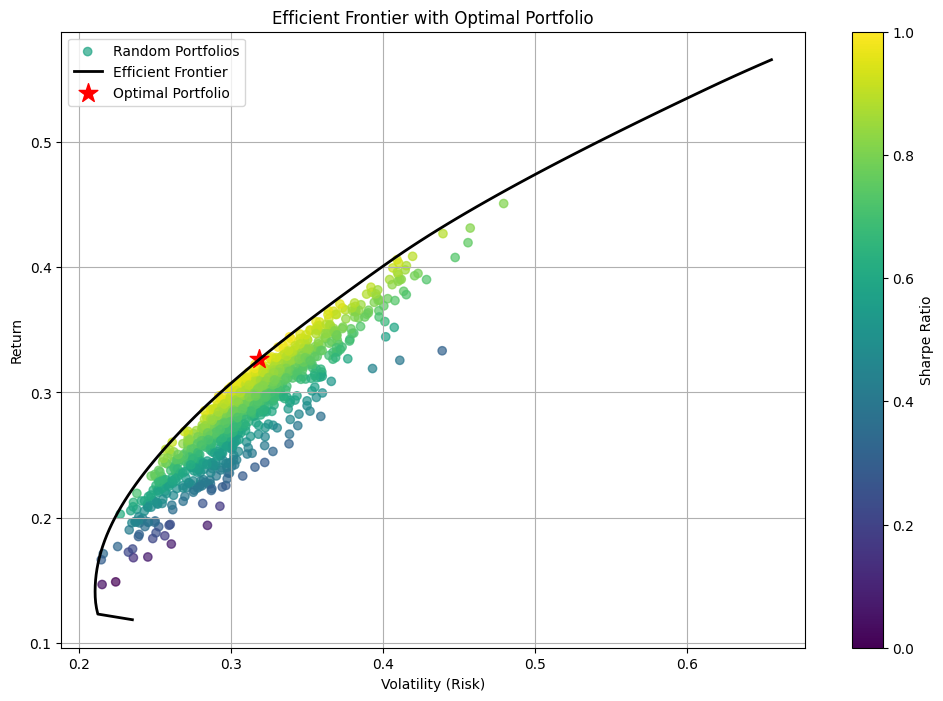

(           Weights
 AAPL  4.632965e-01
 TSLA  2.689411e-17
 NVDA  0.000000e+00
 WMT   2.900706e-01
 JPM   2.466329e-01,
 {'Optimal Portfolio Return': 0.32642817499808896,
  'Optimal Portfolio Volatility': 0.31869175656668114,
  'Optimal Portfolio Sharpe Ratio': 0.9928972697851425})

In [11]:
# Optimize the portfolio
optimal_result = minimize(
    negative_sharpe_ratio,
    np.ones(len(mean_returns)) / len(mean_returns),
    args=(mean_returns, cov_matrix, risk_free_rate),
    method="SLSQP",
    bounds=tuple((0, 1) for _ in range(len(mean_returns))),
    constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
)
optimal_weights = optimal_result.x
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
optimal_sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

# Generate random portfolios for efficient frontier
num_portfolios = 1000
results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

# Calculate efficient frontier
frontier_returns, frontier_volatility = calculate_efficient_frontier(mean_returns, cov_matrix)

# Plot efficient frontier
plt.figure(figsize=(12, 8))
plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap="viridis", marker="o", alpha=0.7, label="Random Portfolios")
plt.plot(frontier_volatility, frontier_returns, color="black", linewidth=2, label="Efficient Frontier")
plt.scatter(optimal_volatility, optimal_return, color="red", marker="*", s=200, label="Optimal Portfolio")
plt.title("Efficient Frontier with Optimal Portfolio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Return")
plt.colorbar(label="Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.show()

# Display results
optimal_weights_df = pd.DataFrame(optimal_weights, index=tickers, columns=['Weights'])
optimal_results_summary = {
    "Optimal Portfolio Return": optimal_return,
    "Optimal Portfolio Volatility": optimal_volatility,
    "Optimal Portfolio Sharpe Ratio": optimal_sharpe_ratio
}

optimal_weights_df, optimal_results_summary

#### Calculated Value at Risk (VAR) of Optimized Portfolio

In [12]:
from scipy.stats import norm

# Calculate Value at Risk (VaR) for the optimized portfolio
confidence_level = 0.95  # Confidence level for VaR
z_score = norm.ppf(1 - confidence_level)  # Z-score for the confidence level
portfolio_var = z_score * optimal_volatility / np.sqrt(252)  # Daily VaR

# Display VaR result
print(f"Value at Risk (VaR) at {confidence_level * 100:.0f}% Confidence: {portfolio_var:.4f}")


Value at Risk (VaR) at 95% Confidence: -0.0330
